# はじめに
公平な機械学習モデルを構築する手法を検証します。

### 概要
- 公平性指標としてEqualized Oddsを使用します。
- Threshold Optimizerを用いて、公平な機械学習モデルを構築します。

# 公平性指標
### Equalized Odds
今回考える公平性指標は、性別や人種などの各グループが公平に扱われているか（group fairness）を評価するために用いられます。
Equalized Oddsは、positiveとnegativeの2クラス分類において、positiveと判定される確率に着目した指標です。
具体的には、正しくpositiveと判定される確率（true positive rate）と、誤ってpositiveと判定される確率（false positive rate）がグループによらず等しいかを評価します。

数式で書くと、性別や人種などの属性の集合を$A$、モデルが予測するクラスの集合を$Y=\{0,1\}$、属性が$a \in A$かつ正解クラスが$y \in Y$のデータが、クラス$\hat{Y} =1$と予測される確率を$P(\hat{Y}=1|A=a, Y=y)$とすると、任意の$y, a, a'$で下記が成り立つ場合、モデルはEqualized Oddsを満たします。

$$
P(\hat{Y}=1|A=a, Y=y) = P(\hat{Y}=1|A=a', Y=y)
$$

# Threshold Optimizer
この手法では、学習後のモデルを調整することで、公正性指標を改善させます。
Equalized Oddsを公平性指標として用いる場合は、ROCカーブを考えます。

ROCカーブとは、0または1を予測する2クラス分類で、モデルが1と予測する閾値（感度）を変えた際にモデルの検知性能がどのように変化するかを描画したグラフです。
様々な閾値でのfalse positive rate $P(\hat{Y}=1|Y=0)$とtrue positive rate
$P(\hat{Y}=1|Y=1)$を評価し、横軸をfalse positive rate、縦軸をtrue positive rateとしたグラフを作成します。

通常のモデルでは、全サンプルで同一の閾値が用いられていますが、Threshold Optimizerでは、グループごとに閾値を最適化します。
具体的には、グループごとにROCカーブを描き、ROCカーブが交差する点を探します。
交差する点は、false positive rateとtrue positive rateがグループによらず同一でEqualized Oddsを満たすため、その点の閾値を採用します。




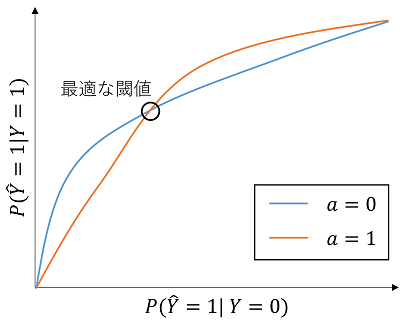

# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb

!pip install fairlearn
from fairlearn.datasets import fetch_adult
from fairlearn.metrics import equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.2 MB/s eta 0:00:00


### 2. データセットの用意
今回は[Adult Data Set](http://archive.ics.uci.edu/ml/datasets/adult)を使用します。
年齢や教育歴などの14の属性から、収入が5万ドルを超えるかどうかを予測するタスクのデータセットで、48,842サンプルが含まれます。
UCI Machine Learning Repositoryからダウンロードすることもできますが、Fairlearnのfetch_adultで取得します。

データを7:3にランダムに分割して、それぞれを教師データとテストデータとして使用します。
ラベルは、Fairlearnで用いられるように'>50K'は1、'<=50K'は0となるように変換しておきます。

In [2]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
print(X.head())
print(X.shape)
print(set(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
y_train = (y_train == '>50K') * 1
y_test = (y_test == '>50K') * 1

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

### 3. 通常の学習
LightGBMでモデルの学習を行います。


In [3]:
lgb_params = {
    'objective' : 'binary',
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

LGBMClassifier(objective='binary')

### 4. Threshold Optimizer
閾値を最適化して、公平性を改善させます。
その後、ROCカーブも描画します。

/usr/local/lib/python3.10/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


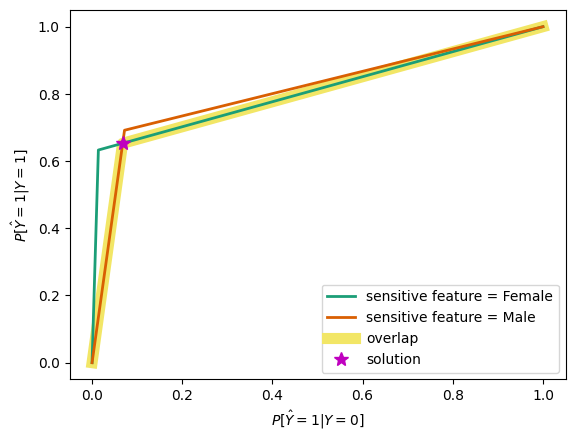

In [5]:
mitigator = ThresholdOptimizer(estimator=model, constraints='equalized_odds')
mitigator.fit(X_train, y_train, sensitive_features=X_train['sex'])

plot_threshold_optimizer(mitigator)

### 5. 公平性評価
モデルの有用性は、今回はF1スコアをsklearn.metrics.f1_scoreで計算します。
公平性指標はEqualized OddsをFairlearnのequalized_odds_differenceで計算します。
この関数は、sensitive_featuresに指定した属性のグループ間のtrue positive rateまたはfalse positive rateの差の最大値を出力します。

これらの指標の散布図を描画して、予測性能と公平性のトレードオフを確認します。


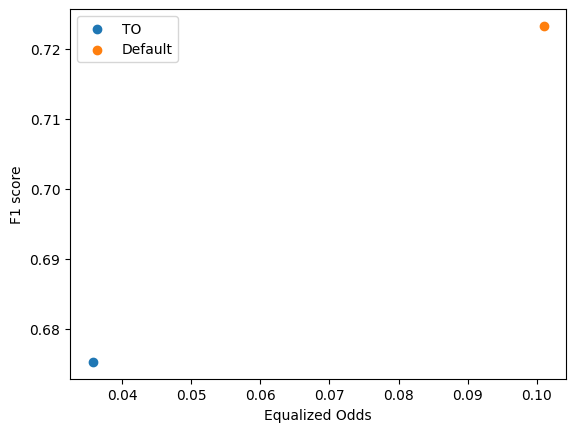

In [6]:
# Postprocessing
pred = mitigator.predict(X_test, sensitive_features=X_test['sex'])
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred), label='TO')

# Default
pred = model.predict(X_test)
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred),  label='Default')
plt.legend()

plt.xlabel('Equalized Odds')
plt.ylabel('F1 score')
plt.show()

# おわりに

### 今回の結果
Threshold Optimizerによってモデルの公平性を改善できることが確認できました。
しかし、Correlation Removerほどではないですが、F1スコアが少し低下してしまっています。


### 次にやること
グループ間の公平性（group fairness）以外の公平性の定義も検証したいと思います。

### 参考資料
- Adult Data Set
http://archive.ics.uci.edu/ml/datasets/adult
- Fairlearn
https://fairlearn.org/v0.8/quickstart.html
- M. Hardt et al., Equality of Opportunity in Supervised Learning, NeurIPS, 2016.
